Authors:
Goto, Ipei B.
Quinto, Christopher A.
Talato, Joshua P.

Acronyms : 
- THI = Total Household Income

Objective: 
1. Explore the data set.
    - See which attributes are continuous / categorial.
        - Visually represent them.
    - Identify which attributes of a household has a relationship with THI.
        - Correctly identify if attributes that has correlations with THI are solely region based or nationwide.

3. Visualize the relationship in a graphical manner

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv("Family Income and Expenditure.csv")

Measuring the data

- There are 41,544 rows. with 60 columns!

In [3]:
df.shape

(41544, 60)

Data types Categorical or Continous


In [4]:
print(df.dtypes)

Total Household Income                            int64
Region                                           object
Total Food Expenditure                            int64
Main Source of Income                            object
Agricultural Household indicator                  int64
Bread and Cereals Expenditure                     int64
Total Rice Expenditure                            int64
Meat Expenditure                                  int64
Total Fish and  marine products Expenditure       int64
Fruit Expenditure                                 int64
Vegetables Expenditure                            int64
Restaurant and hotels Expenditure                 int64
Alcoholic Beverages Expenditure                   int64
Tobacco Expenditure                               int64
Clothing, Footwear and Other Wear Expenditure     int64
Housing and water Expenditure                     int64
Imputed House Rental Value                        int64
Medical Care Expenditure                        

Only pick the int64, i.e the continous variable types.

Create a correlation matrix.

See which ones correlate the most with Total Household Icome

> note that this is for all regions of the Philippines. this is going to be a breath first analysis.

Now let's remove outliers.  
remove all rows that have outliers in at least one column.

Outliers ALWAYS MESS UP THE TRAINING OF THE MODEL. Therefore, it is imperative that we remove such outliers

>( < 3).all(axis=1) checks if, for each row, all column values are within 3 standard deviations from the mean   
>Removes approximately 0.3% of data points

Now, to justify why we removed the columns shown below,  
It is because we are currently only looking to develop a model based on expenditure types.

<Axes: >

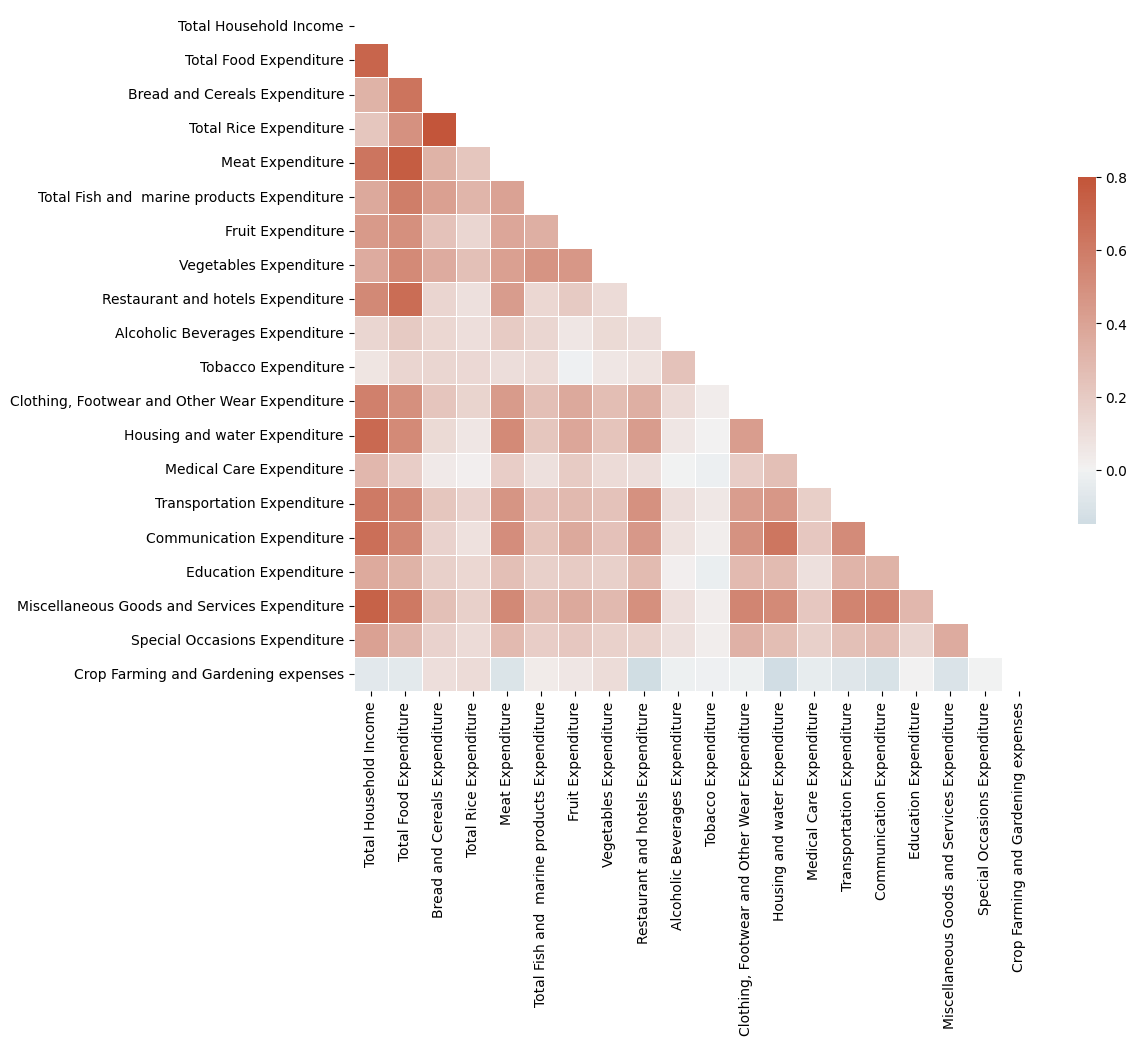

In [5]:
#this code only picks out the columns that is integer type, i.e continous datatype.
continous_df = df.loc[:, df.dtypes == np.int64]

dropped_columns = ['Total Number of Family members',
                   'Members with age less than 5 year old',
                   'Members with age 5 - 17 years old',
                   'Total number of family members employed',
                   'House Floor Area', 
                   'House Age',
                   'Number of bedrooms',
                   'Electricity',
                   'Number of Television',
                   'Number of CD/VCD/DVD',
                   'Number of Component/Stereo set',
                   'Number of Refrigerator/Freezer',
                   'Number of Washing Machine',
                   'Number of Airconditioner',
                   'Number of Car, Jeep, Van',
                   'Number of Landline/wireless telephones',
                   'Number of Cellular phone',
                   'Number of Personal Computer',
                   'Number of Stove with Oven/Gas Range',
                   'Number of Motorized Banca',
                   'Number of Motorcycle/Tricycle',
                   'Household Head Age',
                   'Agricultural Household indicator',
                   'Imputed House Rental Value',
                   'Total Income from Entrepreneurial Acitivites']


continous_df = continous_df.drop(columns=dropped_columns, axis=1)


#this removes all the outliers.
continous_df = continous_df[(np.abs(stats.zscore(continous_df)) < 3).all(axis=1)]

corr = continous_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Printing out the specific values

In [6]:
print(corr['Total Household Income'].sort_values(ascending=False))

Total Household Income                           1.000000
Miscellaneous Goods and Services Expenditure     0.735363
Total Food Expenditure                           0.716781
Housing and water Expenditure                    0.699895
Communication Expenditure                        0.662963
Meat Expenditure                                 0.630590
Transportation Expenditure                       0.605024
Clothing, Footwear and Other Wear Expenditure    0.577841
Restaurant and hotels Expenditure                0.533553
Fruit Expenditure                                0.447552
Special Occasions Expenditure                    0.410937
Total Fish and  marine products Expenditure      0.374377
Education Expenditure                            0.367018
Vegetables Expenditure                           0.358815
Bread and Cereals Expenditure                    0.320619
Medical Care Expenditure                         0.299789
Total Rice Expenditure                           0.222858
Alcoholic Beve

#### From highest to lowest, the expenditures that have a significant correlation with Total Household Income are:
1. Miscellaneous Goods and Services Expenditure     0.735363
2. Total Food Expenditure                           0.716781
3. Housing and water Expenditure                    0.699895
4. Communication Expenditure                        0.662963
5. Meat Expenditure                                 0.630590
6. Transportation Expenditure                       0.605024
7. Clothing, Footwear and Other Wear Expenditure    0.577841
8. Restaurant and hotels Expenditure                0.533553

#### Low Education Expenditure Correlation
>  A surprising observation is that Education doesn't have a strong correlation (a value equal greater than 0.5) to Total Household Income.
#### Meaning that Education expenses isn't an indicator for total household income for the Philippines as a whole 
> Why is that?  
>> Possible reasons  
>> 1. Public Education Systems reduces out of pocket expenses  
>> 2. Education is not as important as other type of expenses, so it gets left behind.  
>>> - Let's see if this holds true if we look at the regions individually.

### Now let's explore the following
#### 1. Regression analysis to validate these correlations
#### 2. Non-linear relationship possibilities
> There might be a possibilty where Education Expenditures has a non-linear relationship   
> with total household income  
#### 3. Potential regional variations in these correlations




In [7]:
# Regression analysis

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare your features and target
#Columns to be dropped
X = continous_df.drop(columns='Total Household Income', axis=1)
y = continous_df['Total Household Income']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)
print("Linear Regression R-squared:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

# Check feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(lr_model.coef_)
})
print(feature_importance.sort_values('importance', ascending=False))

Linear Regression R-squared: 0.7519664058196736
Mean Squared Error: 4353068392.374906
                                          feature  importance
16   Miscellaneous Goods and Services Expenditure    3.697478
14                      Communication Expenditure    3.273945
10  Clothing, Footwear and Other Wear Expenditure    2.332047
8                 Alcoholic Beverages Expenditure    2.213350
17                  Special Occasions Expenditure    1.793054
5                               Fruit Expenditure    1.554132
11                  Housing and water Expenditure    1.331528
13                     Transportation Expenditure    1.190548
12                       Medical Care Expenditure    0.906758
3                                Meat Expenditure    0.732625
15                          Education Expenditure    0.636318
9                             Tobacco Expenditure    0.626803
0                          Total Food Expenditure    0.566950
4     Total Fish and  marine products Expendit

In [8]:
continous_df.aggregate("max")

Total Household Income                           1100552
Total Food Expenditure                            237872
Bread and Cereals Expenditure                      65468
Total Rice Expenditure                             53120
Meat Expenditure                                   42020
Total Fish and  marine products Expenditure        33944
Fruit Expenditure                                  11454
Vegetables Expenditure                             14905
Restaurant and hotels Expenditure                  86300
Alcoholic Beverages Expenditure                     7602
Tobacco Expenditure                                14270
Clothing, Footwear and Other Wear Expenditure      27380
Housing and water Expenditure                     197676
Medical Care Expenditure                           86986
Transportation Expenditure                         69654
Communication Expenditure                          25932
Education Expenditure                              71120
Miscellaneous Goods and Service


Polynomial features involve taking an existing feature and raising it to a power.   
Which is useful for capturing non-linear relationships between the feature and the target variable.   
Which is why we're coding to see if there are any.

In [9]:
#Non Linear Analysis

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Polynomial Regression (2nd degree)
poly_reg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_poly = poly_reg.predict(X_test)
print("Polynomial Regression R-squared:", r2_score(y_test, y_pred_poly))

Polynomial Regression R-squared: 0.7539035618939849


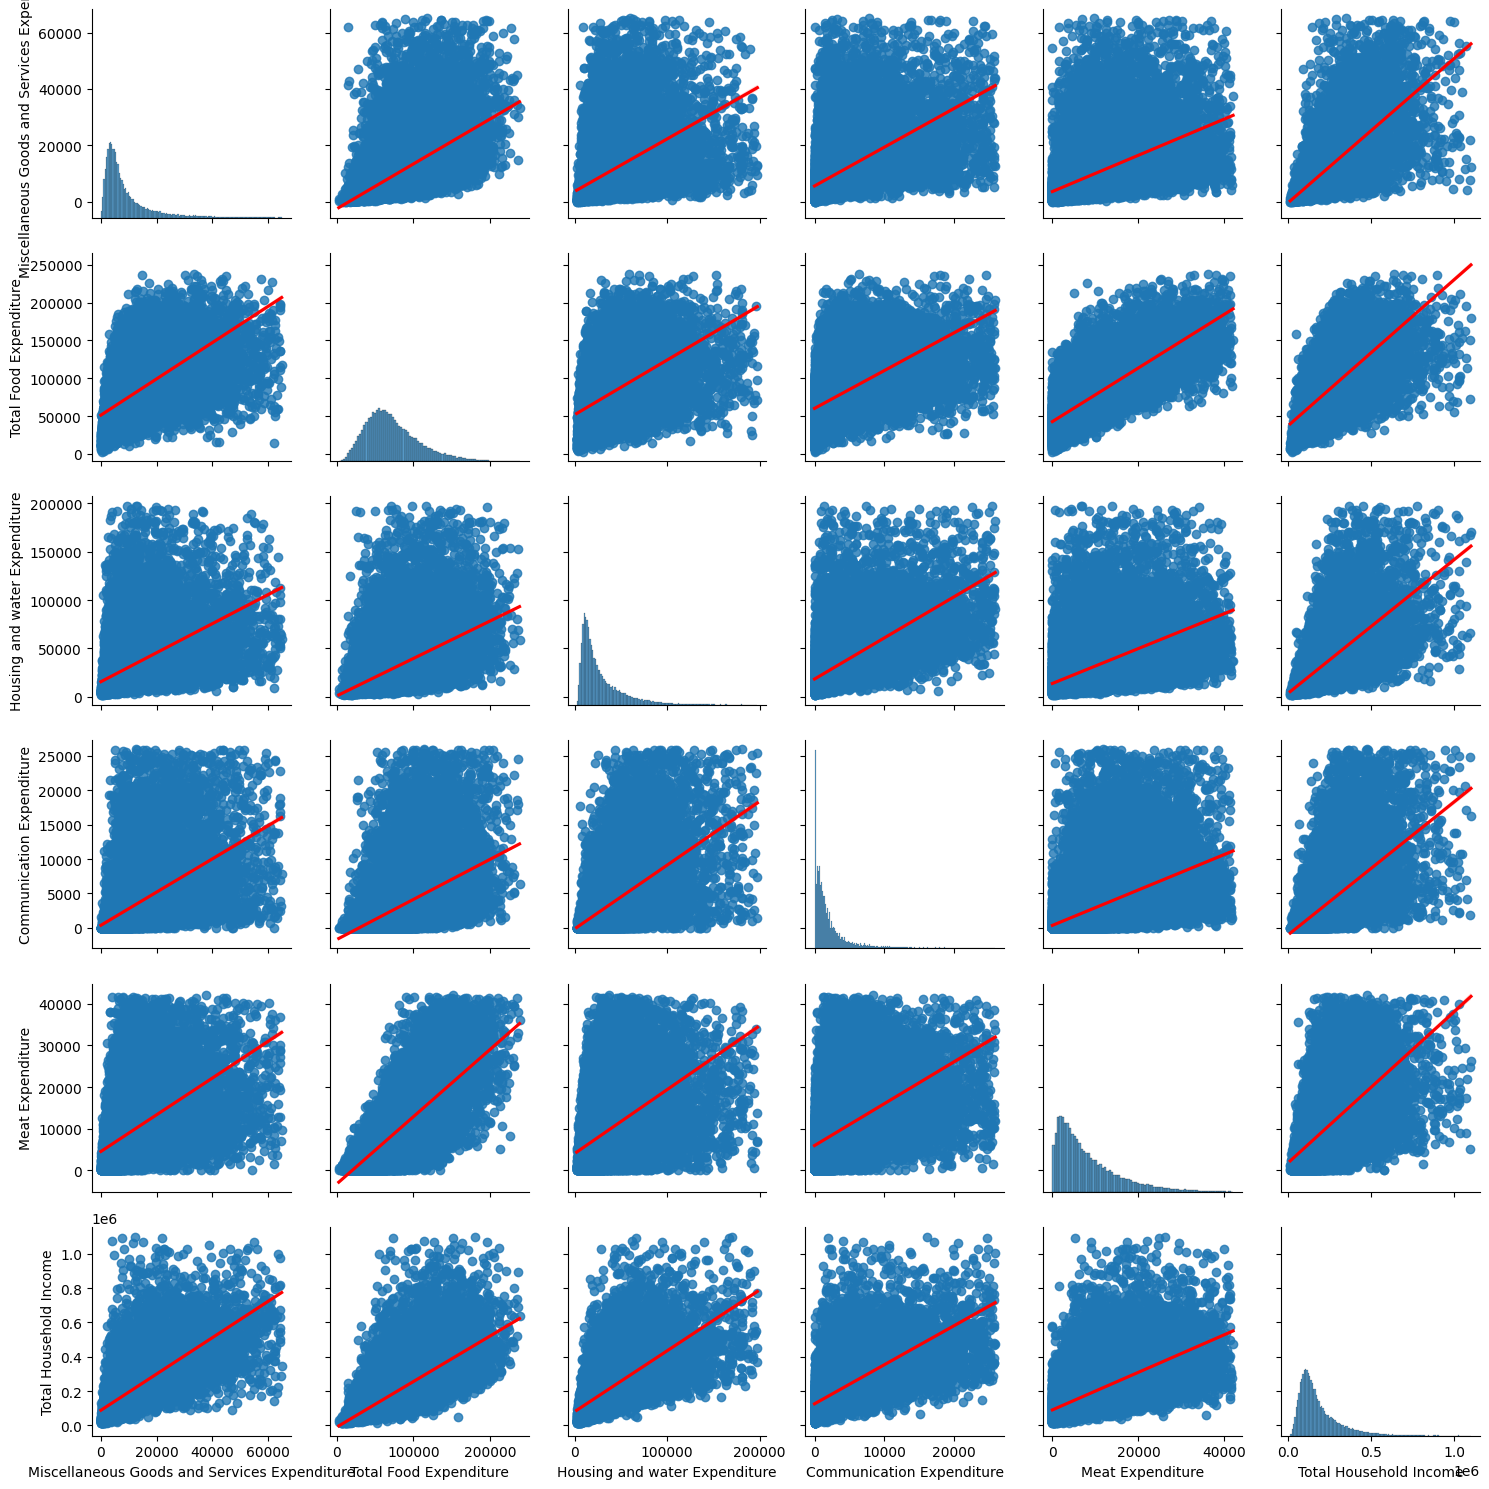

In [10]:

# Pairplot to visualize non-linear relationships
top_correlated_features = corr['Total Household Income'].sort_values(
    ascending=False)[1:6].index.tolist()
sns.pairplot(continous_df[top_correlated_features + ['Total Household Income']],
             kind='reg',
             plot_kws={'line_kws': {'color': 'red'}})
plt.tight_layout()
plt.show()

In [11]:

# Check for non-linear relationships using Spearman correlation
spearman_corr = continous_df.corr(method='spearman')
print("\nSpearman Correlation (captures non-linear relationships):")
print(spearman_corr['Total Household Income'].sort_values(ascending=False))


Spearman Correlation (captures non-linear relationships):
Total Household Income                           1.000000
Total Food Expenditure                           0.784991
Miscellaneous Goods and Services Expenditure     0.772144
Housing and water Expenditure                    0.756665
Communication Expenditure                        0.735055
Meat Expenditure                                 0.700531
Transportation Expenditure                       0.668243
Clothing, Footwear and Other Wear Expenditure    0.593540
Restaurant and hotels Expenditure                0.587855
Fruit Expenditure                                0.470595
Total Fish and  marine products Expenditure      0.451924
Special Occasions Expenditure                    0.435327
Medical Care Expenditure                         0.426673
Vegetables Expenditure                           0.406981
Bread and Cereals Expenditure                    0.405997
Education Expenditure                            0.353187
Total Rice Ex

> A Linear Regression R-squared value of 0.751 indicates a strong  
> linear relationship between the expenditure types and Total Household Income.

> While using the Polynomial Regression, there is a 0.002 improvement.

> The 0.02 improvement using Spearman correlation, which suggests there is non-linear relationship.  
> But it is better to think of it as a liner relationship instead.


### Key takeaways:
1. There is a strong linear relationship with the expenditure variable with Total Household Income   
2. A terrible performance for Linear Regression Model. Looking at the MSE, it performs badly.   
Which means using a Linea Regression model as a predictive model is not good.   
We have to use a different type of model.


# Finding and Creating a Predictive Model  

## We are now going to create a "one size fits all" model. Where the train & test data is from all across regions.  

### In using Principal Component Analysis 
##### Importance of PCA,
> As the number of features or dimensions in a dataset increases, the amount of data required to obtain a statistically significant result increases exponentially.    
> This can lead to issues such as overfitting, increased computation time, and reduced accuracy of machine learning models this is known    
> as the curse of dimensionality problems that arise while working with high-dimensional data.  
##### Correlation Based Feature Selection


In [33]:
# Create a correlation matrix
correlation_matrix = continous_df.corr()

# Identify highly correlated features
high_correlation_features = correlation_matrix[abs(
    correlation_matrix['Total Household Income']) > 0.5]['Total Household Income']
print("Highly Correlated Features:")
print(high_correlation_features)

Highly Correlated Features:
Total Household Income                           1.000000
Total Food Expenditure                           0.716781
Meat Expenditure                                 0.630590
Restaurant and hotels Expenditure                0.533553
Clothing, Footwear and Other Wear Expenditure    0.577841
Housing and water Expenditure                    0.699895
Transportation Expenditure                       0.605024
Communication Expenditure                        0.662963
Miscellaneous Goods and Services Expenditure     0.735363
Name: Total Household Income, dtype: float64


Principal Component Analysis


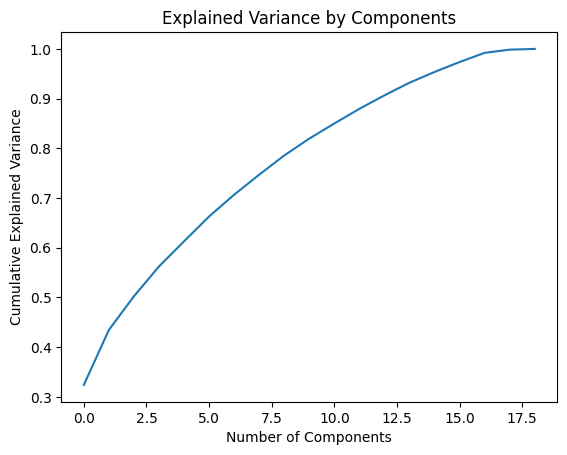

Number of components explaining 95% variance: 15


In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare the features (exclude the target variable)
features = continous_df.drop('Total Household Income', axis=1)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA()
pca.fit(features_scaled)

# Plot cumulative explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

# Select components that explain 95% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

Recursive Feature Elimination

In [39]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Prepare features and target
X = continous_df.drop(['Total Food Expenditure','Total Household Income'], axis=1)
y = continous_df['Total Household Income']

# Create the RFE model
rfe_selector = RFE(estimator=LinearRegression(),
                   n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe_selector.support_]
print("Selected Features via RFE:")
for i in selected_features.tolist():
    print(i)

Selected Features via RFE:
Meat Expenditure
Total Fish and  marine products Expenditure
Fruit Expenditure
Alcoholic Beverages Expenditure
Clothing, Footwear and Other Wear Expenditure
Housing and water Expenditure
Transportation Expenditure
Communication Expenditure
Miscellaneous Goods and Services Expenditure
Special Occasions Expenditure


Lasso Regression for Feature Seletion


In [42]:
from sklearn.linear_model import LassoCV

# Prepare features and target
X = continous_df.drop(
    ['Total Food Expenditure', 'Total Household Income'], axis=1)
y = continous_df['Total Household Income']

# Perform Lasso regression with cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)

# Get important features
important_features = X.columns[lasso.coef_ != 0]
print("Important Features via Lasso:")
for i in selected_features.tolist():
    print(i)

Important Features via Lasso:
Meat Expenditure
Total Fish and  marine products Expenditure
Fruit Expenditure
Alcoholic Beverages Expenditure
Clothing, Footwear and Other Wear Expenditure
Housing and water Expenditure
Transportation Expenditure
Communication Expenditure
Miscellaneous Goods and Services Expenditure
Special Occasions Expenditure


The most consistenly picked features are:
- Selected Features via RFE:
- Meat Expenditure
- Total Fish and  marine products Expenditure
- Fruit Expenditure
- Alcoholic Beverages Expenditure
- Clothing, Footwear and Other Wear Expenditure
- Housing and water Expenditure
- Transportation Expenditure
- Communication Expenditure
- Miscellaneous Goods and Services Expenditure
- Special Occasions Expenditure

And we will pick the five higest correlation amongst these features to get the most amount of variance possible   
while using the least amount of components.
#### These are...   

1. Miscellaneous Goods and Services Expenditure     0.735363
2. Housing and water Expenditure                    0.699895
3. Communication Expenditure                        0.662963
4. Meat Expenditure                                 0.630590
5. Transportation Expenditure                       0.605024

### We will now use these features/variables to predict Total Household Income using multiple machine learning models.

Group By Region:
- See the median Total Food Expenditure
- See the median Total Household Income

In [12]:
df_regions = df.groupby('Region')
Median_MHI_aggregated_df_regions = df_regions.agg(
    Median_Household_Income=('Total Household Income', 'median')
)
Median_MHI_aggregated_df_regions


,Median_Household_Income
Region,
ARMM,111394.0
CAR,188580.0
Caraga,132282.5
I - Ilocos Region,172109.5
II - Cagayan Valley,167560.0
III - Central Luzon,220208.0
IVA - CALABARZON,227757.0
IVB - MIMAROPA,140483.0
IX - Zasmboanga Peninsula,126567.0


In [13]:
Median_TFE_aggregated_df_regions = df_regions.agg(
    Median_Household_Expenditure=('Total Food Expenditure', 'median')
)
#Median_TFE_aggregated_df_regions.rank(ascending=False)
Median_TFE_aggregated_df_regions

,Median_Household_Expenditure
Region,
ARMM,60550.0
CAR,73578.0
Caraga,63514.0
I - Ilocos Region,71974.5
II - Cagayan Valley,68237.0
III - Central Luzon,89919.0
IVA - CALABARZON,94760.0
IVB - MIMAROPA,62590.0
IX - Zasmboanga Peninsula,59256.0
